In [ ]:
# import relevant libraries

import pandas as pd
import numpy as np
import cv2
import os
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import random
from google.colab import drive

In [ ]:
# import the dataset from the google drive

drive.mount('/content/drive')

objects = !unzip '/content/drive/MyDrive/Flowers and Objects Dataset/Objects.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create an instance of SIFT class to be used as a feature descriptor

sift = cv2.xfeatures2d.SIFT_create()

In [ ]:
# create an instance of svm and random forest objects

svm = SVC()
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)

In [ ]:
# create an instance of the encoders

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

## Objects DataSet

In [ ]:
# extract the feature descriptors using sift for each image in the training set
# append all the feature descriptors and then vertically stack them

features = []
train_path = '//content/Objects_Dataset_Images/train'

for i in os.listdir(train_path):
  for im in os.listdir(train_path+'/'+i):
    img = cv2.imread(train_path+'/'+i+'/'+im)
    kp, img_des = sift.detectAndCompute(img, None)
    if img_des is not None:
      features.append(img_des)
features = np.vstack(features)

In [ ]:
# apply kmeans algorithm to the features to build the vocabulary which is merely the centres of each cluster
# k=5 is used as it gave the best performance on this data set

kmeans = KMeans(n_clusters = 5, n_init=10)
kmeans.fit(features)
objects_visual_words = kmeans.cluster_centers_ 

In [ ]:
# represent each image in the training set as a histogram 
  # each feature descriptor of the image is represented as the closest visual word existing in the vocabulary
  # the histogram contains the count of each of the visual word in one image
# labels of each train image is also appended in a list

objects_train_labels = []
objects_train_hist = []

for i in os.listdir(train_path):
  for im in os.listdir(train_path+'/'+i):
    img = cv2.imread(train_path+'/'+i+'/'+im)
    kp, img_des = sift.detectAndCompute(img, None)
    histogram = np.zeros(len(objects_visual_words))
    for d in img_des:
      distances = np.linalg.norm(objects_visual_words - d, axis=1)
      nearest_visual_word = np.argmin(distances)
      histogram[nearest_visual_word] += 1
    objects_train_hist.append(histogram)
    objects_train_labels.append(i)
objects_train_hist = np.vstack(objects_train_hist)

In [ ]:
# similar tasks as the previous cell are done for the test set

objects_test_labels = []
objects_test_hist = []

test_path = '/content/Objects_Dataset_Images/test'
for i in os.listdir(test_path):
  for im in os.listdir(test_path+'/'+i):
    img = cv2.imread(test_path+'/'+i+'/'+im)
    kp, img_des = sift.detectAndCompute(img, None)
    histogram = np.zeros(len(objects_visual_words))
    for d in img_des:
      distances = np.linalg.norm(objects_visual_words - d, axis=1)
      nearest_visual_word = np.argmin(distances)
      histogram[nearest_visual_word] += 1
    objects_test_hist.append(histogram)
    objects_test_labels.append(i)
objects_test_hist = np.vstack(objects_test_hist)

### SVM

In [ ]:
# transform the labels

integer_encoded = label_encoder.fit_transform(objects_train_labels)
objects_train_labels = integer_encoded.reshape(len(integer_encoded), 1)

integer_encoded = label_encoder.fit_transform(objects_test_labels)
objects_test_labels = integer_encoded.reshape(len(integer_encoded), 1)

In [ ]:
# fit the svm classifier for the objects data set

obj_svm = svm.fit(objects_train_hist, objects_train_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# make predictions on the test set

objects_svm_pred = obj_svm.predict(objects_test_hist)

In [ ]:
# accuracy score, f1-score, TPR and FPR

obj_svm_acc = accuracy_score(objects_test_labels, objects_svm_pred)*100
obj_svm_f1 = f1_score(objects_test_labels, objects_svm_pred, average='macro')*100
cnf_matrix = confusion_matrix(objects_test_labels, objects_svm_pred)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
obj_svm_TPR = np.mean(TP/(TP+FN))*100
obj_svm_FPR = np.mean(FP/(FP+TN))*100

print('\nSVM on Objects Dataset\n')

print('Accuracy: ',obj_svm_acc,'%\nF1-Score: ',obj_svm_f1,'%\nTrue Positive Rate: ',obj_svm_TPR,'%\nFalse Positive Rate: ',obj_svm_FPR,'%')


SVM on Objects Dataset

Accuracy:  75.0 %
F1-Score:  74.16666666666667 %
True Positive Rate:  75.0 %
False Positive Rate:  8.333333333333332 %


Run the classifier on few randomly images to show some correct and incorrect classifications

***Note:*** There might be a need to run the below 2 cells multiple times as there might be a chance that the randomly selected contains none of the incorreclty classified images


In [ ]:
selected_obj_svm_images = []
selected_obj_svm_hist = []
selected_obj_svm_labels = []

# randomly select one image in the test set from each class
for i in os.listdir(test_path):
  imgs = random.sample(os.listdir(test_path+'/'+i), 1)
  for im in imgs:
    selected_obj_svm_images.append(test_path+'/'+i+'/'+str(im))
    selected_obj_svm_labels.append(i)

# transform the labels
integer_encoded = label_encoder.fit_transform(selected_obj_svm_labels)
selected_obj_svm_labels = integer_encoded.reshape(len(integer_encoded), 1)

# find the histogram representation for each image
for i in range(len(selected_obj_svm_images)):
  img = cv2.imread(selected_obj_svm_images[i])
  kp, img_des = sift.detectAndCompute(img, None)
  histogram = np.zeros(len(objects_visual_words))
  for d in img_des:
    distances = np.linalg.norm(objects_visual_words - d, axis=1)
    nearest_visual_word = np.argmin(distances)
    histogram[nearest_visual_word] += 1
  selected_obj_svm_hist.append(histogram)
selected_obj_svm_hist = np.vstack(selected_obj_svm_hist)

# make predictions for the selected images
selected_obj_svm_pred = obj_svm.predict(selected_obj_svm_hist)

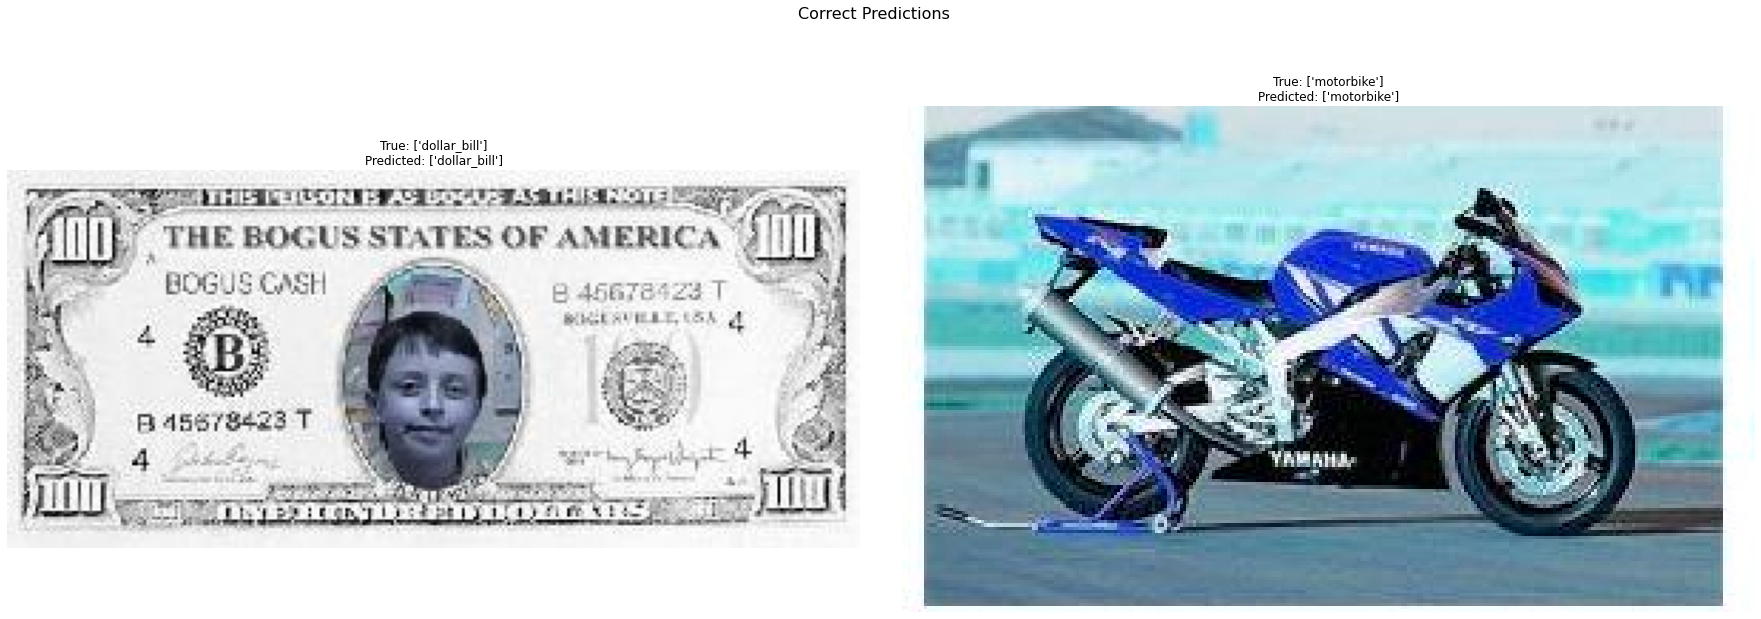

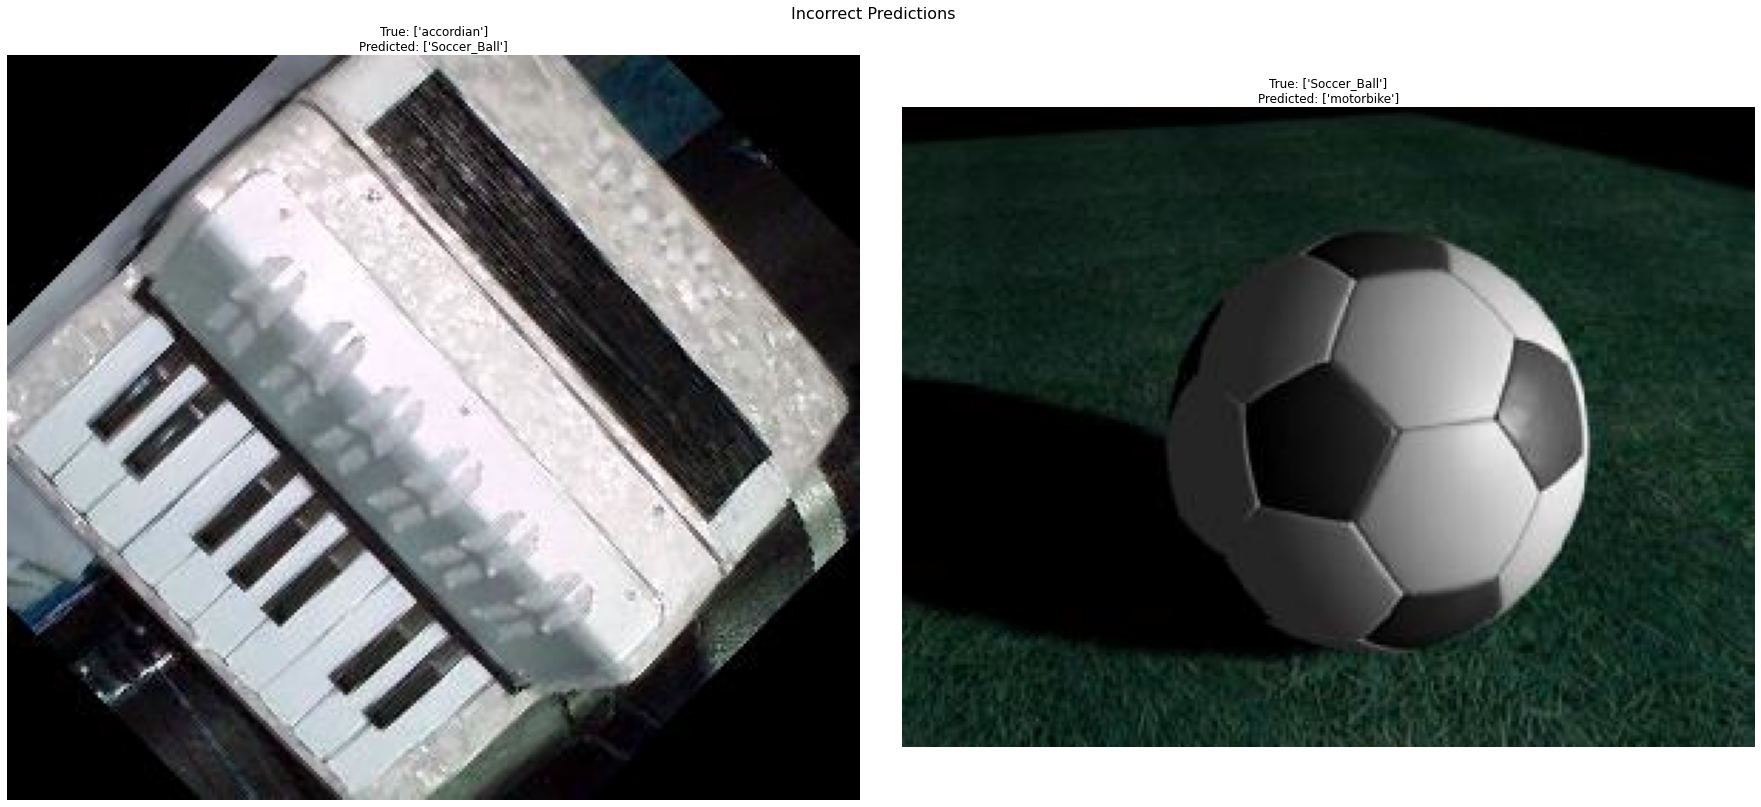

In [ ]:
# Plot the selected images along with their true and predicted labels

cor, incor = 0,0
true, false = 0,0
for i in range(len(selected_obj_svm_images)):
    if selected_obj_svm_labels[i]==selected_obj_svm_pred[i]:
      true+=1
    else:
      false+=1

fig1, axes1 = plt.subplots(1, true, figsize=(25, 10))
fig1.suptitle('Correct Predictions', fontsize=16)
fig1.tight_layout()
fig2, axes2 = plt.subplots(1, false, figsize=(25, 12))
fig2.suptitle('Incorrect Predictions', fontsize=16)
fig2.tight_layout()
for i in range(len(selected_obj_svm_images)):
    img = cv2.imread(selected_obj_svm_images[i])
    if selected_obj_svm_labels[i]==selected_obj_svm_pred[i]:
      axes1[cor].imshow(img)
      axes1[cor].set_title(f"True: {label_encoder.inverse_transform(selected_obj_svm_labels[i])}\nPredicted: {label_encoder.inverse_transform([selected_obj_svm_pred[i]])}")
      axes1[cor].axis('off')
      cor+=1
    else:
      axes2[incor].imshow(img)
      axes2[incor].set_title(f"True: {label_encoder.inverse_transform(selected_obj_svm_labels[i])}\nPredicted: {label_encoder.inverse_transform([selected_obj_svm_pred[i]])}")
      axes2[incor].axis('off')
      incor+=1

plt.show()

### RF

In [ ]:
# transform the labels into one hot encodings

objects_train_rf_labels = onehot_encoder.fit_transform(objects_train_labels)
objects_test_rf_labels = onehot_encoder.fit_transform(objects_test_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# fit the classifier

obj_rf = rf.fit(objects_train_hist, objects_train_rf_labels)

In [ ]:
# make predictions on the test set

objects_rf_pred = obj_rf.predict(objects_test_hist)

In [ ]:
# as predictions contains the probabilites for each class, transform it to the class with the highest probability

for i in objects_rf_pred:
  m=max(i)
  for el in range(len(i)):
    if i[el]==m:
      i[el]=1.0
    else:
      i[el]=0.0

In [ ]:
# accuracy score, f1-score, TPR and FPR

obj_rf_acc = accuracy_score(objects_test_rf_labels, objects_rf_pred)*100
obj_rf_f1 = f1_score(objects_test_rf_labels, objects_rf_pred, average='macro')*100
cnf_matrix = confusion_matrix(objects_test_rf_labels.argmax(axis=1), objects_rf_pred.argmax(axis=1))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
obj_rf_TPR = np.mean(TP/(TP+FN))*100
obj_rf_FPR = np.mean(FP/(FP+TN))*100

print('\nRandom Forest on Objects Dataset\n')

print('Accuracy: ',obj_rf_acc,'%\nF1-Score: ',obj_rf_f1,'%\nTrue Positive Rate: ',obj_rf_TPR,'%\nFalse Positive Rate: ',obj_rf_FPR,'%')


Random Forest on Objects Dataset

Accuracy:  75.0 %
F1-Score:  73.33333333333333 %
True Positive Rate:  75.0 %
False Positive Rate:  8.333333333333332 %


Run the classifier on few randomly images to show some correct and incorrect classifications

***Note:*** There might be a need to run the below 2 cells multiple times as there might be a chance that the randomly selected contains none of the incorreclty classified images


In [ ]:
selected_obj_rf_images = []
selected_obj_rf_hist = []
selected_obj_rf_labels = []

# choose one random image from each class
for i in os.listdir(test_path):
  imgs = random.sample(os.listdir(test_path+'/'+i), 1)
  for im in imgs:
    selected_obj_rf_images.append(test_path+'/'+i+'/'+str(im))
    selected_obj_rf_labels.append(i)

# transform the labels
integer_encoded = label_encoder.fit_transform(selected_obj_rf_labels)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
selected_obj_rf_labels = onehot_encoder.fit_transform(integer_encoded)

# create histograms
for i in range(len(selected_obj_rf_images)):
  img = cv2.imread(selected_obj_rf_images[i])
  kp, img_des = sift.detectAndCompute(img, None)
  histogram = np.zeros(len(objects_visual_words))
  for d in img_des:
    distances = np.linalg.norm(objects_visual_words - d, axis=1)
    nearest_visual_word = np.argmin(distances)
    histogram[nearest_visual_word] += 1
  selected_obj_rf_hist.append(histogram)
selected_obj_rf_hist = np.vstack(selected_obj_rf_hist)

# make predictions for the selected images
selected_obj_rf_pred = obj_rf.predict(selected_obj_rf_hist)
for i in selected_obj_rf_pred:
  m=max(i)
  for el in range(len(i)):
    if i[el]==m:
      i[el]=1.0
    else:
      i[el]=0.0

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


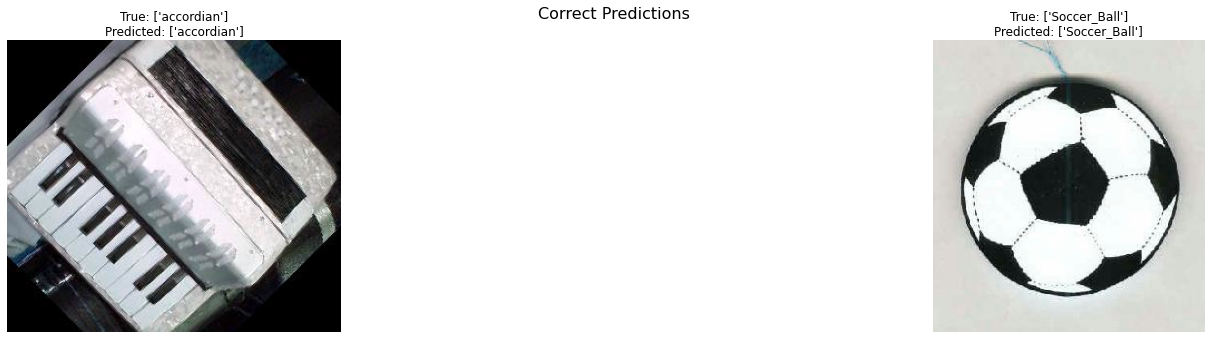

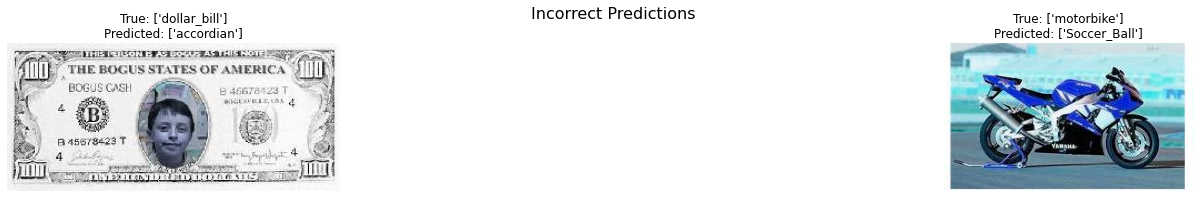

In [ ]:
# Plot the selected images along with their true and predicted labels

cor, incor = 0,0
true, false = 0,0
for i in range(len(selected_obj_rf_images)):
    if selected_obj_rf_labels[i].argmax()==selected_obj_rf_pred[i].argmax():
      true+=1
    else:
      false+=1

fig1, axes1 = plt.subplots(1, true if true<=8 else 8, figsize=(25, 5))
fig1.suptitle('Correct Predictions', fontsize=16)
fig1.tight_layout()
fig2, axes2 = plt.subplots(1, false, figsize=(25,3))
fig2.suptitle('Incorrect Predictions', fontsize=16)
fig2.tight_layout()
for i in range(len(selected_obj_rf_images)):
    img = cv2.imread(selected_obj_rf_images[i])
    if selected_obj_rf_labels[i].argmax()==selected_obj_rf_pred[i].argmax() and cor<8:
      axes1[cor].imshow(img)
      axes1[cor].set_title(f"True: {label_encoder.inverse_transform([selected_obj_rf_labels[i].argmax()])}\nPredicted: {label_encoder.inverse_transform([selected_obj_rf_pred[i].argmax()])}")
      axes1[cor].axis('off')
      cor+=1
    elif cor<8:
      axes2[incor].imshow(img)
      axes2[incor].set_title(f"True: {label_encoder.inverse_transform([selected_obj_rf_labels[i].argmax()])}\nPredicted: {label_encoder.inverse_transform([selected_obj_rf_pred[i].argmax()])}")
      axes2[incor].axis('off')
      incor+=1
plt.show()